### COLLABORATIVE FILTERING (Surprise SVD)

Exploration du module Surprise modèle SVD

### Imports 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from surprise import Dataset
from surprise import Reader

from surprise import SVD

from sklearn.metrics import roc_auc_score

import itertools

## Data imports 

In [3]:
df_train = pd.read_csv('filtered data/filtered_rating_fm_dataset_train.csv', index_col=0)

C:\Users\Alumet\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
df_train = df_train.groupby(['user_id','track_id']).first().reset_index()

In [5]:
df_test = pd.read_csv('filtered data/filtered_rating_fm_dataset_test.csv', index_col=0)

## Data Preparation

In [ ]:
reader = Reader(rating_scale=(1, 101))
data = Dataset.load_from_df(df_train[['user_id', 'track_id', 'rating']], reader)

In [ ]:
trainset = data.build_full_trainset()

## Class Metrique

In [6]:
class k_best():
    def __init__(self, user_tracks, recomended_tracks):
        self.user_tracks = user_tracks
        self.recomended_tracks = recomended_tracks
    
    def CG(self):
        
        return len(set(self.recomended_tracks).intersection(set(self.user_tracks)))
    
    def DCG(self):
        
        result = 0
        for i,id in enumerate(self.recomended_tracks):
            
            if id in self.user_tracks:
                result+=1/np.log2(i+2)

        return result
    
    def IDCG(self):
        
        a = self.CG()
        result=0
        
        for i in range (a):
            result+=1/np.log2(i+2)
        
        return result
    
    def NDCG(self):
        if self.IDCG()!=0:
            result = self.DCG()/self.IDCG()
        else:
            result=0
            
        return result
    
    def P_at_k(self):
        
        return self.CG()/len(self.recomended_tracks)

    
    def __str__(self):
        
        result = 'K_best ressults: \n'
        result+= f'CG = {self.CG()}\n'
        result+= f'DCG = {self.DCG()}\n'
        result+= f'NDCG = {self.NDCG()}\n'
        result+= f'P@K = {self.P_at_k()}\n'
        
        return result

In [7]:
def get_reco(model, df_train, user_id, n=50):
    
    scores=[]
    track_ids=[]
    user_ids=[]

    for track_id in df_train['track_id'].unique():
        score = model.predict(user, track_id, r_ui=1)[3]
    
        user_ids.append(user)
        track_ids.append(track_id)
        scores.append(score)
    
    recommendation = pd.DataFrame({'user_id':user_ids,'track_id':track_ids,'score':scores})
    
    if n>=0:
        recommendation = recommendation.sort_values(by=['score'], ascending=False).iloc[:n]
    
    return recommendation
    

## Modèle simple SVD

In [113]:
svd = SVD()
svd = svd.fit(trainset)

### Test sur un utilisateur

In [51]:
user = 1

In [52]:
recommendation = get_reco(svd, df_train, user)
recomended_tracks = [x for x in recommendation['track_id'].values]

In [53]:
user_tracks_train = set([x for x in df_train[df_train['user_id']==user]['track_id'].unique()])
user_tracks_test = set([x for x in df_test[df_test['user_id']==user]['track_id'].unique()])

## K_best

In [54]:
k = k_best(user_tracks_train, recomended_tracks)
print(k)

K_best ressults: 
CG = 15
DCG = 5.016255088925719
NDCG = 0.8558193594076898
P@K = 0.3



In [55]:
k = k_best(user_tracks_test, recomended_tracks)
print(k)

K_best ressults: 
CG = 2
DCG = 0.7640098914067264
NDCG = 0.46845052016107697
P@K = 0.04



### AUC_ROC

In [69]:
recommendation = get_reco(svd, df_train, user,-1)

In [70]:
recommendation['train'] = recommendation['track_id'].apply(lambda x: 1 if x in user_tracks_train else 0)
recommendation['test'] = recommendation['track_id'].apply(lambda x: 1 if x in user_tracks_test else 0)

In [96]:
y_pred = [1 if x>50 else 0 for x in recommendation['score']]

In [97]:
roc_train = roc_auc_score(recommendation['train'],y_pred)
roc_test = roc_auc_score(recommendation['test'],y_pred)

print('Train_AUC_ROC = ', roc_train)
print('Test_AUC_ROC = ', roc_test)

Train_AUC_ROC =  0.5047375432342011
Test_AUC_ROC =  0.5025327844471983


## Grid serch (optimisation des paramètres)

In [24]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [10,20,30],
              'n_factors': [50,100,150]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=3, refit=True)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

9.096555799617077
{'n_epochs': 30, 'n_factors': 150}


In [25]:
a = gs.cv_results['mean_test_rmse']
b = gs.cv_results['params']

for score, param in zip(a,b):
    print(score,param )

9.837754845049126 {'n_epochs': 10, 'n_factors': 50}
9.32386556333249 {'n_epochs': 10, 'n_factors': 100}
9.11776572514284 {'n_epochs': 10, 'n_factors': 150}
10.034276419663408 {'n_epochs': 20, 'n_factors': 50}
9.316282703191417 {'n_epochs': 20, 'n_factors': 100}
9.10185345341999 {'n_epochs': 20, 'n_factors': 150}
10.126120091690014 {'n_epochs': 30, 'n_factors': 50}
9.322619304961968 {'n_epochs': 30, 'n_factors': 100}
9.096555799617077 {'n_epochs': 30, 'n_factors': 150}


## Entrainement du meilleur model

In [26]:
svd = SVD(n_factors=150, n_epochs=30)
svd = svd.fit(trainset)

## Evaluation sur tous les utilisateurs

### K_best

In [16]:
train_scores = list()
test_scores = list()
user_id = list()

for user in tqdm(df_train['user_id'].unique()):
    user_tracks_train = set([x for x in df_train[df_train['user_id']==user]['track_id'].unique()])
    user_tracks_test = set([x for x in df_test[df_test['user_id']==user]['track_id'].unique()])
    
    recommendation = get_reco(svd, df_train, user,-1)
    recomended_tracks = [x for x in recommendation['track_id'].values]
    
    k = k_best(user_tracks_train, recomended_tracks)
    train_scores.append(k.NDCG())
    
    if len(user_tracks_test)!=0:
        k = k_best(user_tracks_test, recomended_tracks)
        test_scores.append(k.NDCG())
        
    else:
        test_scores.append(0)
    
    user_id.append(user)

100%|████████████████████████████████████████████████████████████████████████████████| 959/959 [10:08<00:00,  1.58it/s]


In [17]:
# best n_fact=150, it=30
print('Train_mean_NDCG = ', np.array(train_scores).mean())
print('Test_mean_NDCG = ', np.array(test_scores).mean())

Train_mean_NDCG =  0.9464651953669875
Test_mean_NDCG =  0.13541589533096676


### AUC_ROC

In [19]:
scores = dict()

for s in np.linspace(0,100,10):
    scores[s]={'train':[], 'test':[]}


for user in tqdm(df_train['user_id'].unique()):
    
    user_tracks_train = set([x for x in df_train[df_train['user_id']==user]['track_id'].unique()])
    user_tracks_test = set([x for x in df_test[df_test['user_id']==user]['track_id'].unique()])
    
    recomended_tracks = get_reco(svd, df_train, user,-1)
    
    recomended_tracks['true_train'] = recomended_tracks['track_id'].apply(lambda x: 1 if x in user_tracks_train else 0)
    recomended_tracks['true_test'] = recomended_tracks['track_id'].apply(lambda x: 1 if x in user_tracks_test else 0)
    
    for s in np.linspace(0,100,10):
    
        recomended_tracks['pred'] = recomended_tracks['score'].apply(lambda x : 1 if x>s else 0)
        y_pred = recomended_tracks['pred'].values

        y_true_train = recomended_tracks['true_train'].values
        score = roc_auc_score(y_true_train, y_pred)  
        scores[s]['train'].append(score)

        y_true_test = recomended_tracks['true_test'].values
        score = roc_auc_score(y_true_test, y_pred)
        scores[s]['test'].append(score)

100%|████████████████████████████████████████████████████████████████████████████████| 959/959 [19:52<00:00,  1.24s/it]


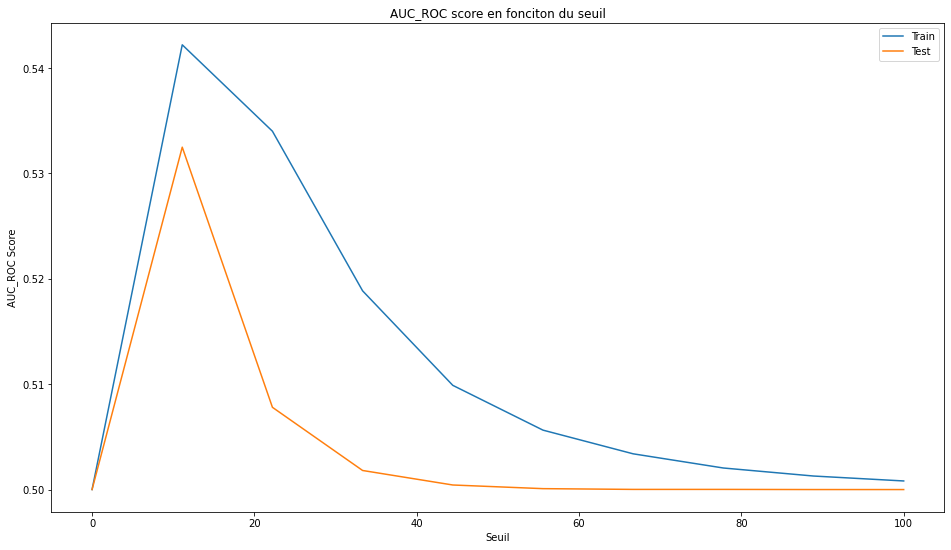

In [20]:
train_score = list()
test_score = list()
seuil = list()

for key in scores.keys():
    train_score.append(np.array(scores[key]['train']).mean())
    test_score.append(np.array(scores[key]['test']).mean())
    seuil.append(key)


plt.figure(figsize=(16,9))
plt.plot(seuil, train_score, label='Train')
plt.plot(seuil, test_score, label='Test')
plt.legend()

plt.title('AUC_ROC score en fonciton du seuil')
plt.xlabel('Seuil')
plt.ylabel('AUC_ROC Score')
plt.show

plt.savefig("AUC_ROC score en fonction du seuil, SVD_Surprise", dpi=300, pad_inches=0.1,bbox_inches='tight')

In [23]:
i = np.array(train_score).argmax()

print('Train_best_AUC_ROC = ', round(train_score[i],3))
print('Test_best_AUC_ROC = ', round(test_score[i],3))
print('Seuil_best = ', round(seuil[i],3))

Train_best_AUC_ROC =  0.542
Test_best_AUC_ROC =  0.532
Seuil_best =  11.111
